(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Analyzing hotel ratings on Tripadvisor

In this homework we will focus on practicing two techniques: web scraping and regression. For the first part, we will build upon the sample code from the Lecture and attempt to get some basic information for each hotel. Then, we will fit a regression model on this information and try to analyze it.   

One of the main disadvantages of scraping a website instead of using an API is that, without any notice, the website may change its layout and render our code useless. Something like that happened in our case. Tripadvisor changed the layout of the buttons that we use to navigate between the different pages of the results. This was the main reason people were having problem with executing the code.

**Task 1 (20 pts)**

The first task of the homework is to fix the scraping code. We basically need to replace the part where we are checking if there is another page and getting its link with new code that reflects the new navigation layout. 

** Task 2 (30 pts)**

Then, for each hotel that our search returns, we will "click" (with the code of course) on it and scrape the information below.

![Information to be scraped](hotel_info.png)

Of course, feel free to collect even more data if you want. 

** Task 3 (20 pts) **

Now, we will use regression to analyze this information. First, we will fit a linear regression model that predicts the average rating. For example, for the hotel above, the average rating is

$$ \text{AVG_SCORE} = \frac{1*31 + 2*33 + 3*98 + 4*504 + 5*1861}{2527}$$

Use the model to analyze the important factors that decide the $\text{AVG_SCORE}$.

** Task 4 (30 pts) **

Finally, we will use logistic regression to decide if a hotel is _excellent_ or not. We classify a hotel as _excellent_ if more than **60%** of its ratings are 5 stars. This is a binary attribute on which we can fit a logistic regression model. As before, use the model to analyze the data.

-------

In order to use code from a Python script file, we need to put that file in the same folder as the notebook and import it as a library. Then, we will be able to access it's functions. For example, in the case of the lecture code, we could do the following:

``` python
import scrape_solution as scrape

scrape.get_city_page()
```

Of course, you might need to modify and restructure the code so that it returns what you need.

----

In [1]:
import scrape_solution as scrape

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('hotel.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 17 columns):
STAR             77 non-null float64
TOTAL_REV        77 non-null int64
EXCELLENT        77 non-null int64
VERY_GOOD        77 non-null int64
AVERAGE          77 non-null int64
POOR             77 non-null int64
TERRIBLE         77 non-null int64
FAMILIES         77 non-null int64
COUPLES          77 non-null int64
SOLO             77 non-null int64
BUSINESS         77 non-null int64
LOCATION         77 non-null float64
SLEEP_QUALITY    77 non-null float64
ROOM             77 non-null float64
SERVICE          77 non-null float64
VALUE            77 non-null float64
CLEANLINESS      77 non-null float64
dtypes: float64(7), int64(10)

In [4]:
df['SCORE'] = df['STAR'] * df['TOTAL_REV']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 18 columns):
STAR             77 non-null float64
TOTAL_REV        77 non-null int64
EXCELLENT        77 non-null int64
VERY_GOOD        77 non-null int64
AVERAGE          77 non-null int64
POOR             77 non-null int64
TERRIBLE         77 non-null int64
FAMILIES         77 non-null int64
COUPLES          77 non-null int64
SOLO             77 non-null int64
BUSINESS         77 non-null int64
LOCATION         77 non-null float64
SLEEP_QUALITY    77 non-null float64
ROOM             77 non-null float64
SERVICE          77 non-null float64
VALUE            77 non-null float64
CLEANLINESS      77 non-null float64
SCORE            77 non-null float64
dtypes: float64(8), int64(10)

In [5]:
df_norm = (df - df.mean()) / (df.max() - df.min())

df_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 18 columns):
STAR             77 non-null float64
TOTAL_REV        77 non-null float64
EXCELLENT        77 non-null float64
VERY_GOOD        77 non-null float64
AVERAGE          77 non-null float64
POOR             77 non-null float64
TERRIBLE         77 non-null float64
FAMILIES         77 non-null float64
COUPLES          77 non-null float64
SOLO             77 non-null float64
BUSINESS         77 non-null float64
LOCATION         77 non-null float64
SLEEP_QUALITY    77 non-null float64
ROOM             77 non-null float64
SERVICE          77 non-null float64
VALUE            77 non-null float64
CLEANLINESS      77 non-null float64
SCORE            77 non-null float64
dtypes: float64(18)

In [6]:
df.head()

,STAR,TOTAL_REV,EXCELLENT,VERY_GOOD,AVERAGE,POOR,TERRIBLE,FAMILIES,COUPLES,SOLO,BUSINESS,LOCATION,SLEEP_QUALITY,ROOM,SERVICE,VALUE,CLEANLINESS,SCORE
0,4.5,2540,1872,506,98,33,31,461,550,108,1104,4.5,4.5,4.5,4.5,4.5,5.0,11430.0
1,4.0,1167,479,424,164,67,33,239,335,105,326,4.5,4.0,4.0,4.5,4.0,4.5,4668.0
2,4.5,2937,2365,439,81,39,13,910,851,146,585,5.0,5.0,5.0,5.0,4.5,5.0,13216.5
3,4.5,1248,990,189,43,15,11,284,461,55,255,5.0,4.5,4.5,5.0,4.5,5.0,5616.0
4,4.5,354,244,81,21,7,1,102,101,28,62,4.5,4.0,4.5,4.5,4.5,5.0,1593.0


In [7]:
df_norm.head()

,STAR,TOTAL_REV,EXCELLENT,VERY_GOOD,AVERAGE,POOR,TERRIBLE,FAMILIES,COUPLES,SOLO,BUSINESS,LOCATION,SLEEP_QUALITY,ROOM,SERVICE,VALUE,CLEANLINESS,SCORE
0,0.233766,0.345171,0.586784,0.118240,-0.042096,-0.057046,0.025193,0.254014,0.159507,0.176811,0.784187,-0.00974,0.155844,0.171429,0.114286,0.389610,0.301948,0.408632
1,-0.016234,0.035098,-0.002721,0.062947,0.077686,0.083450,0.040230,0.011126,0.017499,0.164763,0.077556,-0.00974,-0.044156,-0.028571,0.114286,0.056277,0.051948,0.027438
2,0.233766,0.434827,0.795417,0.073062,-0.072949,-0.032253,-0.110145,0.745261,0.358318,0.329422,0.312797,0.24026,0.355844,0.371429,0.314286,0.389610,0.301948,0.509342
3,0.233766,0.053391,0.213530,-0.095515,-0.141914,-0.131426,-0.125183,0.060360,0.100722,-0.036040,0.013070,0.24026,0.155844,0.171429,0.314286,0.389610,0.301948,0.080879
4,0.233766,-0.148506,-0.102170,-0.168341,-0.181842,-0.164484,-0.200371,-0.138765,-0.137058,-0.144474,-0.162226,-0.00974,-0.044156,0.171429,0.114286,0.389610,0.301948,-0.145909


In [8]:
y = df['SCORE']
X = df.drop(['STAR','TOTAL_REV','FAMILIES','COUPLES','SOLO','BUSINESS','SCORE'],axis=1)
model = sm.OLS(y, X)
model_norm = sm.OLS(df_norm['SCORE'], df_norm.drop(['STAR','TOTAL_REV','FAMILIES','COUPLES','SOLO','BUSINESS','SCORE'],axis=1))

In [9]:
results = model.fit()
print results.summary()
print "Confidence Intervals:", results.conf_int()
print "Parameters:", results.params

                            OLS Regression Results                            
Dep. Variable:                  SCORE   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.005e+04
Date:                Sat, 02 May 2015   Prob (F-statistic):          7.26e-102
Time:                        13:12:49   Log-Likelihood:                -482.82
No. Observations:                  77   AIC:                             987.6
Df Residuals:                      66   BIC:                             1013.
Df Model:                          11                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
EXCELLENT         4.8720      0.059     82.592      0.000         4.754     4.990
VERY_GOOD         3.6451      0.234     15.

In [10]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape

(61, 11) (61,)
(16, 11) (16,)


The results lack the X_train.shape, reason see above part.

In [12]:
regr = linear_model.LinearRegression(normalize=True)
regr.fit(X_train, y_train);

In [13]:
print("Training error: ", metrics.mean_squared_error(regr.predict(X_train),y_train))
print("Test     error: ", metrics.mean_squared_error(regr.predict(X_test),y_test))

('Training error: ', 17607.872938811328)
('Test     error: ', 13662.896026849228)


In [14]:
train_score = regr.score(X_train,y_train)
test_score = regr.score(X_test,y_test)
print("Training score: ", train_score)
print("Test     score: ", test_score)

('Training score: ', 0.99838163790258638)
('Test     score: ', 0.99751273164625287)


In [15]:
regr = linear_model.LinearRegression()
scores = cross_validation.cross_val_score(regr, X, y, cv=5)
print scores

[ 0.98899679  0.98992551  0.99579816  0.99556998  0.99309379]


In [16]:
print("Regression score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Regression score: 0.99 (+/- 0.01)


In [17]:
df['IS_EXCELLENT'] = (df['EXCELLENT'] / df['TOTAL_REV']) > 0.6

In [18]:
y = df['IS_EXCELLENT']
X = df.drop(['STAR','TOTAL_REV','FAMILIES','COUPLES','SOLO','BUSINESS','SCORE','IS_EXCELLENT'],axis=1)

In [19]:
df.groupby('LOCATION').mean()

,STAR,TOTAL_REV,EXCELLENT,VERY_GOOD,AVERAGE,POOR,TERRIBLE,FAMILIES,COUPLES,SOLO,BUSINESS,SLEEP_QUALITY,ROOM,SERVICE,VALUE,CLEANLINESS,SCORE,IS_EXCELLENT
LOCATION,,,,,,,,,,,,,,,,,,
3.0,2.500000,18.000000,2.000000,2.000000,8.000000,1.000000,5.000000,4.000000,3.000000,2.000000,3.000000,2.500000,2.500000,2.500000,3.000000,3.000000,45.000000,0.000000
3.5,3.166667,295.000000,40.666667,85.666667,85.333333,47.333333,36.333333,76.333333,78.000000,20.333333,41.333333,3.166667,3.166667,3.333333,3.333333,3.500000,932.666667,0.000000
4.0,3.700000,647.400000,170.100000,256.800000,131.300000,57.600000,31.700000,189.700000,157.100000,43.300000,144.300000,3.600000,3.950000,3.950000,3.800000,4.100000,2398.250000,0.000000
4.5,4.073171,987.804878,433.975610,349.024390,130.853659,46.024390,28.121951,215.292683,281.707317,66.341463,256.000000,4.170732,4.085366,4.256098,3.914634,4.439024,4057.146341,0.146341
5.0,4.295455,1364.318182,807.272727,378.318182,108.636364,45.363636,24.772727,302.863636,472.590909,77.727273,293.681818,4.431818,4.295455,4.454545,4.090909,4.636364,5854.113636,0.500000


In [20]:
df.groupby('SLEEP_QUALITY').mean()

,STAR,TOTAL_REV,EXCELLENT,VERY_GOOD,AVERAGE,POOR,TERRIBLE,FAMILIES,COUPLES,SOLO,BUSINESS,LOCATION,ROOM,SERVICE,VALUE,CLEANLINESS,SCORE,IS_EXCELLENT
SLEEP_QUALITY,,,,,,,,,,,,,,,,,,
2.5,2.500000,18.000000,2.000000,2.000000,8.000000,1.000000,5.000000,4.000000,3.000000,2.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.000000,45.000000,0.000000
3.0,3.166667,426.000000,46.666667,119.666667,135.333333,78.000000,47.000000,80.000000,118.000000,33.666667,101.333333,3.666667,3.166667,3.333333,3.166667,3.500000,1325.666667,0.000000
3.5,3.636364,626.909091,172.909091,247.090909,122.727273,49.545455,34.636364,153.727273,162.636364,44.909091,152.272727,4.136364,3.772727,3.863636,3.772727,4.000000,2340.772727,0.000000
4.0,3.946429,1102.928571,415.607143,426.071429,164.321429,61.678571,35.428571,249.607143,321.035714,79.285714,264.750000,4.553571,3.982143,4.160714,3.875000,4.410714,4364.732143,0.035714
4.5,4.338710,1111.096774,651.967742,316.483871,90.935484,33.193548,18.645161,239.225806,367.709677,60.838710,261.258065,4.709677,4.338710,4.467742,4.080645,4.596774,4848.161290,0.419355
5.0,4.500000,1458.000000,1162.000000,213.333333,49.333333,22.666667,10.666667,426.666667,407.000000,74.333333,344.333333,5.000000,4.666667,4.833333,4.166667,5.000000,6561.000000,1.000000


In [21]:
df.groupby('CLEANLINESS').mean()

,STAR,TOTAL_REV,EXCELLENT,VERY_GOOD,AVERAGE,POOR,TERRIBLE,FAMILIES,COUPLES,SOLO,BUSINESS,LOCATION,SLEEP_QUALITY,ROOM,SERVICE,VALUE,SCORE,IS_EXCELLENT
CLEANLINESS,,,,,,,,,,,,,,,,,,
3.0,2.750000,103.500000,10.500000,17.000000,32.500000,24.500000,19.000000,30.500000,17.000000,7.000000,22.000000,3.250000,2.750000,2.750000,2.750000,3.000000,306.000000,0.000000
3.5,3.125000,490.000000,67.000000,155.000000,137.500000,72.000000,58.750000,85.000000,140.750000,54.500000,96.750000,4.125000,3.375000,3.000000,3.500000,3.500000,1517.375000,0.000000
4.0,3.666667,654.833333,181.666667,251.666667,132.333333,53.916667,35.333333,193.083333,162.250000,44.833333,124.666667,4.166667,3.708333,3.791667,4.041667,3.833333,2410.708333,0.000000
4.5,4.153061,1127.285714,516.714286,398.632653,135.734694,49.387755,27.000000,240.816327,353.591837,71.959184,276.204082,4.632653,4.224490,4.183673,4.275510,3.918367,4683.959184,0.142857
5.0,4.500000,1263.000000,959.000000,225.300000,47.800000,20.000000,10.900000,310.200000,388.500000,63.000000,306.600000,4.800000,4.600000,4.550000,4.700000,4.350000,5683.500000,1.000000


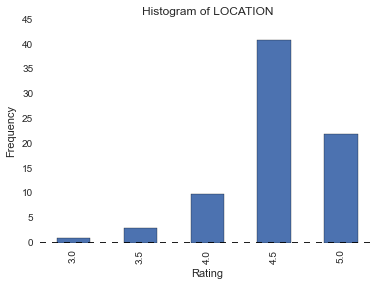

In [22]:
df.LOCATION.value_counts().sort_index().plot(kind='bar')
plt.title('Histogram of LOCATION')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

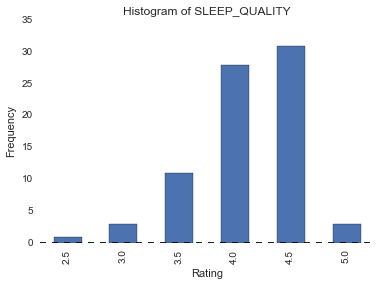

In [23]:
df.SLEEP_QUALITY.value_counts().sort_index().plot(kind='bar')
plt.title('Histogram of SLEEP_QUALITY')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

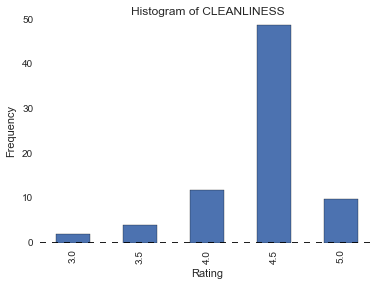

In [24]:
df.CLEANLINESS.value_counts().sort_index().plot(kind='bar')
plt.title('Histogram of CLEANLINESS')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [25]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,
                                                                     y,
                                                                     test_size=0.2,
                                                                     random_state=0
                                                                     )
logistic_regr = linear_model.LogisticRegression()
logistic_regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [26]:
y_predicted = logistic_regr.predict(X_test)
print y_predicted

[False False  True False False False False  True False False  True False
  True False False  True]


In [27]:
probs = logistic_regr.predict_proba(X_test)
print probs

[[  1.00000000e+00   2.39272079e-32]
 [  1.00000000e+00   2.83571036e-27]
 [  2.50730802e-07   9.99999749e-01]
 [  1.00000000e+00   6.95674936e-21]
 [  1.00000000e+00   5.12023371e-28]
 [  1.00000000e+00   5.29338462e-15]
 [  9.94879334e-01   5.12066643e-03]
 [  3.20970433e-02   9.67902957e-01]
 [  9.99998130e-01   1.87023713e-06]
 [  1.00000000e+00   5.35078426e-17]
 [  5.58630412e-05   9.99944137e-01]
 [  1.00000000e+00   3.99744192e-53]
 [  0.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   3.52931781e-17]
 [  1.00000000e+00   1.64179974e-22]
 [  1.24029675e-09   9.99999999e-01]]


In [28]:
print metrics.accuracy_score(y_test, y_predicted)

1.0


In [29]:
print metrics.confusion_matrix(y_test, y_predicted)

[[11  0]
 [ 0  5]]


In [30]:
print metrics.classification_report(y_test, y_predicted)

             precision    recall  f1-score   support

      False       1.00      1.00      1.00        11
       True       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00        16



In [31]:
print pd.DataFrame(zip(X.columns, np.transpose(logistic_regr.coef_)))

                0                   1
0       EXCELLENT   [0.0985724052833]
1       VERY_GOOD   [-0.131985369558]
2         AVERAGE   [-0.172777263979]
3            POOR    [-0.15757702593]
4        TERRIBLE   [-0.333495538372]
5        LOCATION  [-0.0356655423352]
6   SLEEP_QUALITY  [-0.0238386471611]
7            ROOM  [-0.0236206720001]
8         SERVICE  [-0.0237030758005]
9           VALUE  [-0.0373379121732]
10    CLEANLINESS  [-0.0343828774749]


In [32]:
scores = cross_validation.cross_val_score(linear_model.LogisticRegression(),
                                          X,
                                          y,
                                          scoring='accuracy',
                                          cv=10)
print scores

[ 1.     1.     0.875  1.     1.     1.     1.     1.     1.     1.   ]


In [33]:
print scores.mean()

0.9875


In [34]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()